In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

from PIL import Image    


# Preprocessing
This is where we preprocess the data

### Load in data from directories

#### Trying to do zero padding

In [ ]:
# Get the max height and width of dataset
paths = pd.read_csv("train_images.csv")

max_w = 0
max_h = 0
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')

    h = np.shape(rgb_img)[0]
    w = np.shape(rgb_img)[1]

    if (h > max_h):
        max_h = h
    if (w > max_w):
        max_w = w

# We do + 1 to make sure that each image has at least one layer of padding around it
max_h = max_h + 1
max_w = max_w + 1
print("max H: ", max_h)    
print("max W: ", max_w)



max H:  501
max W:  501


h 357
w 500
left 0
right 1
up 72
down 72
h 501
w 501
left 0
right 0
up 0
down 0


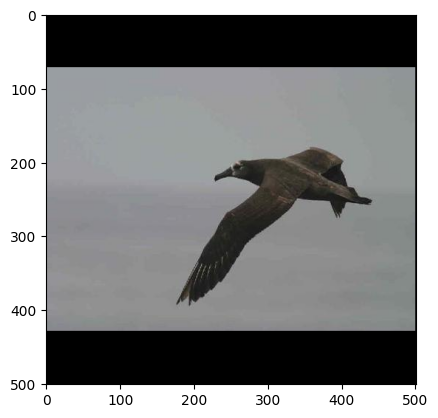

In [ ]:
# loading in and storing train to a vector
# can't store it in numpy array due to diff in dimensionality
paths = pd.read_csv("train_images.csv")

X = []
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')
    rgb_img = np.array(rgb_img)
    
    # calculate the amount of padding
    h = np.shape(rgb_img)[0]
    w = np.shape(rgb_img)[1]

    # print("h", h)
    # print("w", w)

    pad_left = (max_w - w) // 2
    pad_right = max_w - w - pad_left

    pad_up = (max_h - h) // 2
    pad_down = max_h - h - pad_up

    # print("left", pad_left)
    # print("right", pad_right)
    # print("up", pad_up)
    # print("down", pad_down)

    # Actually perform the padding
    rgb_img = np.pad(rgb_img, pad_width=((pad_up, pad_down), (pad_left, pad_right), (0,0)))

    # # calculate the amount of padding
    # h = np.shape(rgb_img)[0]
    # print("h", h)
    # w = np.shape(rgb_img)[1]
    # print("w", w)

    # pad_left = (max_w - w) // 2
    # pad_right = max_w - w - pad_left

    # pad_up = (max_h - h) // 2
    # pad_down = max_h - h - pad_up

    # print("left", pad_left)
    # print("right", pad_right)
    # print("up", pad_up)
    # print("down", pad_down)
    # plt.imshow(rgb_img)

    X.append(rgb_img)

X = np.array(X)

X
plt.imshow(X[0])




In [ ]:
# loading in and storing train to a vector
# can't store it in numpy array due to diff in dimensionality
paths = pd.read_csv("train_images.csv")

X = []
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')

    # calculate the amount of padding
    h = np.shape(rgb_img)[0]
    w = np.shape(rgb_img)[1]

    pad_left = (max_w - w) // 2
    pad_right = max_w - w - pad_left

    pad_up = (max_h - h) // 2
    pad_down = max_h - h - pad_up

    

    X.append(rgb_img)

X = np.array(X)

X
plt.imshow(X[0])

(500, 415, 3)


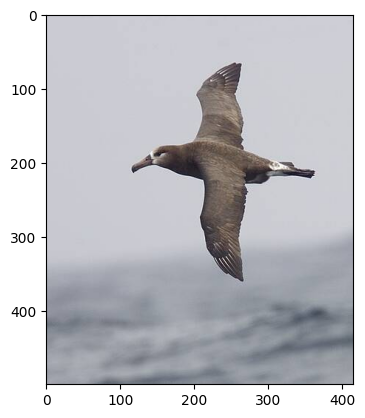

In [13]:
curr_path = paths["image_path"][2]
rgb_img = Image.open("." + curr_path).convert('RGB')
print(np.shape(rgb_img))
plt.imshow(rgb_img)

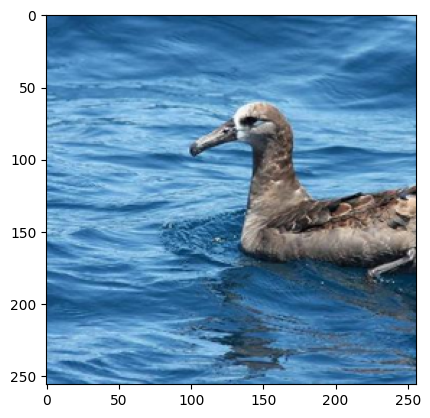

In [4]:
# loading in and storing train to a vector
# can't store it in numpy array due to diff in dimensionality
paths = pd.read_csv("train_images.csv")

X = []
for i in paths.index:
    # The dot makes it so that it's relative to your current dir,
    curr_path = paths["image_path"][i]
    rgb_img = Image.open("." + curr_path).convert('RGB')

    # Resize to 256, 256
    width = np.shape(rgb_img)[0]
    height = np.shape(rgb_img)[1]

    if width == height:
        rgb_img = rgb_img.resize((256,256))
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            rgb_img = rgb_img.crop((left,top,right,bottom))
            rgb_img = rgb_img.resize((256,256))
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            rgb_img = rgb_img.crop((left,top,right,bottom))
            rgb_img = rgb_img.resize((256,256))
    

    X.append(rgb_img)

X = np.array(X)

X
plt.imshow(X[0])

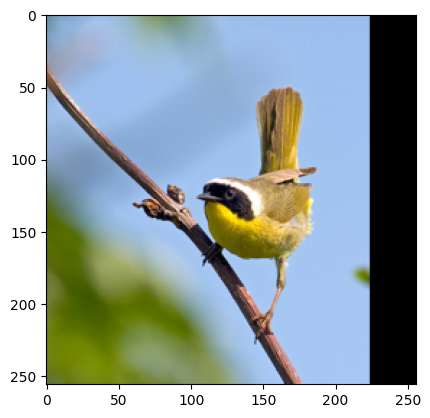

In [45]:
np.shape(X)
for i in paths.index:
    plt.imshow(X[i])

In [6]:

Y = paths["label"]
Y

0         1
1         1
2         1
3         1
4         1
       ... 
3921    200
3922    200
3923    200
3924    200
3925    200
Name: label, Length: 3926, dtype: int64

2


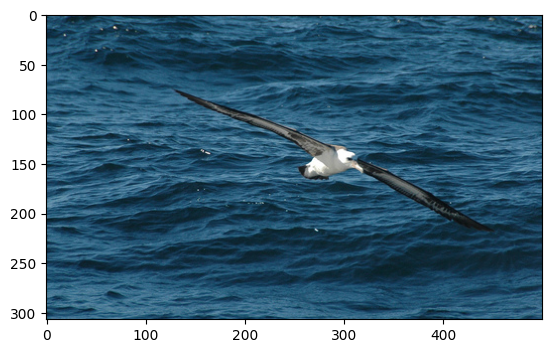

In [13]:
# testing out if this matches nicely
index = 35
plt.imshow(X[index])
print(Y[index])

### Some exploration of the data

In [3]:
# temp 

data = pd.read_csv("/Users/micolcandoni/Documents/GitHub/AppliedMLProject/aml-2025-feathers-in-focus/train_images.csv")

data.head(10)

,image_path,label
0,/train_images/1.jpg,1
1,/train_images/2.jpg,1
2,/train_images/3.jpg,1
3,/train_images/4.jpg,1
4,/train_images/5.jpg,1
5,/train_images/6.jpg,1
6,/train_images/7.jpg,1
7,/train_images/8.jpg,1
8,/train_images/9.jpg,1
9,/train_images/10.jpg,1


In [4]:
from collections import Counter


#count how many images per label 

counts_labels = data['label'].value_counts().sort_index().reset_index()
counts_labels.columns = ['Label', 'Count']


for i in counts_labels.iterrows():
    print(i[1])

Label     1
Count    35
Name: 0, dtype: int64
Label     2
Count    35
Name: 1, dtype: int64
Label     3
Count    33
Name: 2, dtype: int64
Label     4
Count    35
Name: 3, dtype: int64
Label     5
Count    19
Name: 4, dtype: int64
Label     6
Count    16
Name: 5, dtype: int64
Label     7
Count    28
Name: 6, dtype: int64
Label     8
Count    23
Name: 7, dtype: int64
Label     9
Count    34
Name: 8, dtype: int64
Label    10
Count    34
Name: 9, dtype: int64
Label    11
Count    33
Name: 10, dtype: int64
Label    12
Count    31
Name: 11, dtype: int64
Label    13
Count    33
Name: 12, dtype: int64
Label    14
Count    33
Name: 13, dtype: int64
Label    15
Count    33
Name: 14, dtype: int64
Label    16
Count    33
Name: 15, dtype: int64
Label    17
Count    32
Name: 16, dtype: int64
Label    18
Count    20
Name: 17, dtype: int64
Label    19
Count    32
Name: 18, dtype: int64
Label    20
Count    32
Name: 19, dtype: int64
Label    21
Count    32
Name: 20, dtype: int64
Label    22
Count    31

In [5]:
print(counts_labels)

     Label  Count
0        1     35
1        2     35
2        3     33
3        4     35
4        5     19
..     ...    ...
195    196      6
196    197      5
197    198      5
198    199      5
199    200      5

[200 rows x 2 columns]


In [6]:
print(counts_labels['Label'].head())

0    1
1    2
2    3
3    4
4    5
Name: Label, dtype: int64


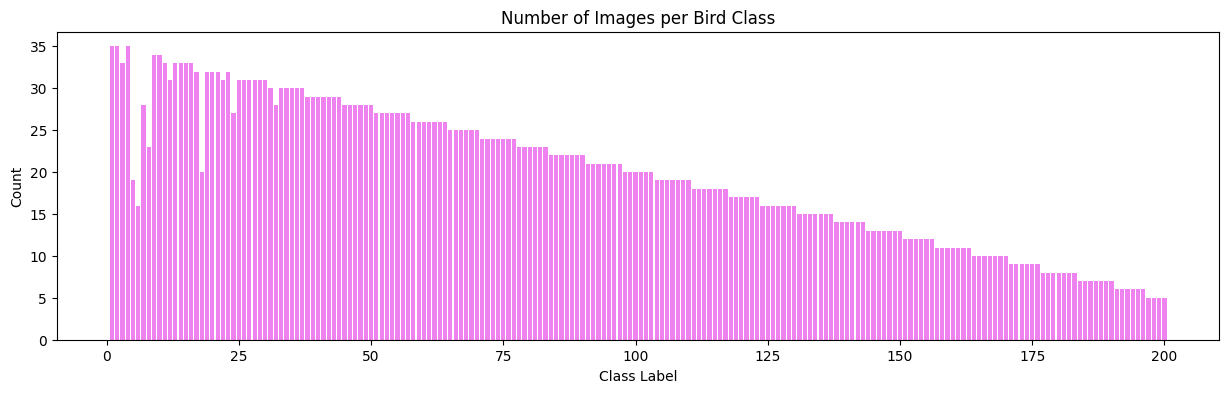

In [7]:
#viualise counts in a plot

import matplotlib.pyplot as plt

plt.figure(figsize = (15, 4))
plt.bar(counts_labels['Label'], counts_labels['Count'], color = 'violet')
plt.title("Number of Images per Bird Class")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [8]:
data['label'].value_counts().head()      # Most common

label
1     35
4     35
2     35
9     34
10    34
Name: count, dtype: int64

In [9]:
data['label'].value_counts().tail()      # Least common

label
196    6
197    5
198    5
199    5
200    5
Name: count, dtype: int64

### Make sure all data is in the same size

In [ ]:
# check CNN

### Potentially Data Augmentation

In [ ]:
# temp

# Training models

### Downloaded model

In [ ]:
# temp

### Simple model

In [3]:
# temp

### Complex model (enseble methods)

In [4]:
#temp

# Comparing models
Here we need to decide what metric to use in order to compare them.

In [ ]:
# temp